# CatBoost Starter for Brain Comp
EEGの差分の集計特徴量を用いたNotebook。

- ver1: CV , LB 

### Version Notes
- Version 1 - EEGのT=20, 30, 40秒における、10秒時間窓 / 20秒時間窓のmean, min, max, std, max-minを特徴量とした。また、データの1/20のみ利用。
- Version 2 - EEGのT=20, 30秒における、10秒時間窓 / 20秒時間窓のmean, min, max, std, max-minを特徴量とした。時間窓に必要な部分のみ計算することで高速化した。

# Load Libraries

In [21]:
import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import time
pl.Config.set_tbl_cols(-1)

VER = 2

# Load Train Data

In [22]:
df_train = pl.read_csv('../input/hms-harmful-brain-activity-classification/train.csv')
TARGETS = df_train.columns[-6:]
print('Train shape:', df_train.shape )
print('Targets', list(TARGETS))
df_train.head()

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']


eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
i64,i64,f64,i64,i64,f64,i64,i64,str,i64,i64,i64,i64,i64,i64
1628180742,0,0.0,353733,0,0.0,127492639,42516,"""Seizure""",3,0,0,0,0,0
1628180742,1,6.0,353733,1,6.0,3887563113,42516,"""Seizure""",3,0,0,0,0,0
1628180742,2,8.0,353733,2,8.0,1142670488,42516,"""Seizure""",3,0,0,0,0,0
1628180742,3,18.0,353733,3,18.0,2718991173,42516,"""Seizure""",3,0,0,0,0,0
1628180742,4,24.0,353733,4,24.0,3080632009,42516,"""Seizure""",3,0,0,0,0,0


# Create Multiple Eeg Id Train Data
データの説明[here][1]には、テストデータには、同じ `eeg_id` からの複数の crop は含まれていないと記載されている。<br>
ひとつの`eeg_id`ごとのデータにする

[1]: https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/467021

In [23]:
df_train = df_train.group_by(by = 'eeg_id').agg(
    pl.min("eeg_label_offset_seconds").alias("eeg_min_offset"),
    pl.max("eeg_label_offset_seconds").alias("eeg_max_offset"),
    pl.first("patient_id"),
    pl.sum("seizure_vote"),
    pl.sum("lpd_vote"),
    pl.sum("gpd_vote"),
    pl.sum("lrda_vote"),
    pl.sum("grda_vote"),
    pl.sum("other_vote"),
    pl.first("expert_consensus")
)
df_train.head()


# 各vote列の合計
df_train = df_train.with_columns(
    (pl.col('seizure_vote') + pl.col('lpd_vote') + pl.col('gpd_vote') + pl.col('lrda_vote') + pl.col('grda_vote') + pl.col('other_vote')).alias('vote_sum')
)

# 各vote列の正規化
df_train = df_train.with_columns(
    (pl.col('seizure_vote') / pl.col('vote_sum')).alias('seizure_vote'),
    (pl.col('lpd_vote') / pl.col('vote_sum')).alias('lpd_vote'),
    (pl.col('gpd_vote') / pl.col('vote_sum')).alias('gpd_vote'),
    (pl.col('lrda_vote') / pl.col('vote_sum')).alias('lrda_vote'),
    (pl.col('grda_vote') / pl.col('vote_sum')).alias('grda_vote'),
    (pl.col('other_vote') / pl.col('vote_sum')).alias('other_vote'),
)

# vote列の削除
df_train = df_train.drop(["vote_sum"])

# expert_consensus列をtarget列とする
df_train = df_train.rename({"expert_consensus": "target"})
df_train.head()

eeg_id,eeg_min_offset,eeg_max_offset,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target
i64,f64,f64,i64,f64,f64,f64,f64,f64,f64,str
1651831947,0.0,72.0,20606,0.058824,0.058824,0.369748,0.0,0.058824,0.453782,"""Other"""
738321828,0.0,68.0,30631,0.0,0.727273,0.0,0.136364,0.0,0.136364,"""LPD"""
1766767927,0.0,10.0,53102,0.0,0.933333,0.0,0.0,0.0,0.066667,"""LPD"""
4030290342,0.0,10.0,18699,0.0,0.333333,0.0,0.0,0.333333,0.333333,"""LPD"""
3748650718,0.0,0.0,65378,0.0,0.0,0.0,0.0,0.0,1.0,"""Other"""


# Feature Engineer


CatBoostモデルに入れる特徴量を作成する。


In [24]:
# parameter
# 差分特徴量の集計特徴量をつくる
# window = 4000 # 20秒窓 (20秒 / (1レコード1/200秒) = 4000レコード)
window_list = [1000, 2000]
center_seconds_list = [20, 30]

In [27]:
def create_aggregated_features_on_EEG_differences(df_eeg_diff, window, center_sec):
    """
    @Args
    df_eeg_diff : 差分特徴量を持つデータフレーム
    window      : 時間窓として抽出する行数 [行]
    center_sec  : 時間窓の中心時刻 [s]
    
    @Returns
    df_features    : 集計特徴量を持つデータフレーム
    """
    ### 時間窓の設定
    window_time = window / (200)
    str_window = str(int(window_time)) + "s"

    # 時間窓 [window_min, window_max] に入るレコードのみ抽出
    window_max = center_sec + (window / 2)
    window_min = center_sec - (window / 2)

    df_eeg_diff = df_eeg_diff.filter((pl.col("seconds_eeg") <= window_max) & (pl.col("seconds_eeg") >= window_min))
    df_eeg_diff = df_eeg_diff.drop(['seconds_eeg'])

    
    ### 特徴量作成
    
    df_features = df_eeg_diff.group_by(by = "eeg_id").agg(
        # LL: Fp1 - T3
        pl.col("LL_Fp1-T3").mean().alias("mean_" + str_window + "_LL_Fp1-T3"),
        pl.col("LL_Fp1-T3").max().alias("min_" + str_window + "_LL_Fp1-T3"),
        pl.col("LL_Fp1-T3").min().alias("max_" + str_window + "_LL_Fp1-T3"),
        pl.col("LL_Fp1-T3").std().alias("std_" + str_window + "_LL_Fp1-T3"),
        (pl.col("LL_Fp1-T3").max() - pl.col("LL_Fp1-T3").min()).alias("max-min_" + str_window + "_LL_Fp1-T3"),

        # LL: Fp1 - T3
        pl.col("LL_T3-O1").mean().alias("mean_" + str_window + "_LL_T3-O1"),
        pl.col("LL_T3-O1").max().alias("min_" + str_window + "_LL_T3-O1"),
        pl.col("LL_T3-O1").min().alias("max_" + str_window + "_LL_T3-O1"),
        pl.col("LL_T3-O1").std().alias("std_" + str_window + "_LL_T3-O1"),
        (pl.col("LL_T3-O1").max() - pl.col("LL_T3-O1").min()).alias("max-min__" + str_window + "_LL_T3-O1"),


        # LP: Fp1 - C3
        pl.col("LP_Fp1-C3").mean().alias("mean_" + str_window + "_LP_Fp1-C3"),
        pl.col("LP_Fp1-C3").max().alias("min_" + str_window + "_LP_Fp1-C3"),
        pl.col("LP_Fp1-C3").min().alias("max_" + str_window + "_LP_Fp1-C3"),
        pl.col("LP_Fp1-C3").std().alias("std_" + str_window + "_LP_Fp1-C3"),
        (pl.col("LP_Fp1-C3").max() - pl.col("LP_Fp1-C3").min()).alias("max-min_" + str_window + "_LP_Fp1-C3"),

        # LP: C3 - O1
        pl.col("LP_C3-O1").mean().alias("mean_" + str_window + "_LP_C3-O1"),
        pl.col("LP_C3-O1").max().alias("min_" + str_window + "_LP_C3-O1"),
        pl.col("LP_C3-O1").min().alias("max_" + str_window + "_LP_C3-O1"),
        pl.col("LP_C3-O1").std().alias("std_" + str_window + "_LP_C3-O1"),
        (pl.col("LP_C3-O1").max() - pl.col("LP_C3-O1").min()).alias("max-min_" + str_window + "_LP_C3-O1"),


        # RP: Fp1 - C4
        pl.col("RP_Fp2-C4").mean().alias("mean_" + str_window + "_RP_Fp2-C4"),
        pl.col("RP_Fp2-C4").max().alias("min_" + str_window + "_RP_Fp2-C4"),
        pl.col("RP_Fp2-C4").min().alias("max_" + str_window + "_RP_Fp2-C4"),
        pl.col("RP_Fp2-C4").std().alias("std_" + str_window + "_RP_Fp2-C4"),
        (pl.col("RP_Fp2-C4").max() - pl.col("RP_Fp2-C4").min()).alias("max-min_" + str_window + "_RP_Fp2-C4"),

        # RP: C4 - O2
        pl.col("RP_C4-O2").mean().alias("mean_" + str_window + "_RP_C4-O2"),
        pl.col("RP_C4-O2").max().alias("min_" + str_window + "_RP_C4-O2"),
        pl.col("RP_C4-O2").min().alias("max_" + str_window + "_RP_C4-O2"),
        pl.col("RP_C4-O2").std().alias("std_" + str_window + "_RP_C4-O2"),
        (pl.col("RP_C4-O2").max() - pl.col("RP_C4-O2").min()).alias("max-min_" + str_window + "_RP_C4-O2"),


        # RR: Fp2 - T4
        pl.col("RR_Fp2-T4").mean().alias("mean_" + str_window + "_RR_Fp2-T4"),
        pl.col("RR_Fp2-T4").max().alias("min_" + str_window + "_RR_Fp2-T4"),
        pl.col("RR_Fp2-T4").min().alias("max_" + str_window + "_RR_Fp2-T4"),
        pl.col("RR_Fp2-T4").std().alias("std_" + str_window + "_RR_Fp2-T4"),
        (pl.col("RR_Fp2-T4").max() - pl.col("RR_Fp2-T4").min()).alias("max-min_" + str_window + "_RR_Fp2-T4"),

        # RR: T4 - O2
        pl.col("RR_T4-O2").mean().alias("mean_" + str_window + "_RR_T4-O2"),
        pl.col("RR_T4-O2").max().alias("min_" + str_window + "_RR_T4-O2"),
        pl.col("RR_T4-O2").min().alias("max_" + str_window + "_RR_T4-O2"),
        pl.col("RR_T4-O2").std().alias("std_" + str_window + "_RR_T4-O2"),
        (pl.col("RR_T4-O2").max() - pl.col("RR_T4-O2").min()).alias("max-min_" + str_window + "_RR_T4-O2"),
    )

    
    # 差分特徴量をdrop
    df_features = df_features.drop(['LL_Fp1-T3', 'LL_T3-O1', 'LP_Fp1-C3', 'LP_C3-O1', 'RP_Fp2-C4', 'RP_C4-O2', 'RR_Fp2-T4', 'RR_T4-O2'])
    
    # 列名を一括で変更
    col_suffix = "_at_" + str(center_sec) + "s"
    list_original_col = df_features.columns
    df_features = df_features.with_columns(pl.all().name.suffix(col_suffix)).drop(list_original_col) # suffixを付与して、元の列名の列を削除
    
    # eeg_id 列の列名を戻す
    eeg_col = "eeg_id_at_" + str(center_sec) + "s"
    df_features = df_features.rename({eeg_col : "eeg_id"})


    return df_features

In [28]:
%%time
PATH = '../input/hms-harmful-brain-activity-classification/train_eegs/'
files = os.listdir(PATH)
print(f'There are {len(files)} eeg parquet files')

start = time.time()
df_all_diff_features = pl.DataFrame()
for i, f in enumerate(files):
    if i%100 == 0:
        print(i, ', ', end = '')
        
        ### 状況確認
        # 時間計測
        end = time.time()
        seconds = end - start
        seconds = int(seconds + 0.5)    # 秒数を四捨五入
        h = seconds // 3600             # 時の取得
        m = (seconds - h * 3600) // 60  # 分の取得
        s = seconds - h * 3600 - m * 60 # 秒の取得
        print(f"{h:02}:{m:02}:{s:02}" )
        start = time.time()

        # 形状確認
        print(df_all_diff_features.shape)

    # if i%10 != 0: continue

    eeg_id = int(f.split('.')[0])    

    # 読み込み
    temp_eeg = pl.read_parquet(f'{PATH}{f}')

    # eeg_id を追加
    temp_eeg = temp_eeg.with_columns(pl.lit(str(eeg_id)).alias("eeg_id"))

    # eegデータにおける、計測開始から各行までの秒数 seconds_eeg
    t = 1/200 # EEGのサンプリング周波数は200Hzなので、1行は1/200秒ごとの計測値を表す
    temp_eeg = temp_eeg.with_row_count("id")
    temp_eeg = temp_eeg.with_columns((pl.col("id") * t).alias("seconds_eeg"))   # 計測時刻の列をつくる
    temp_eeg = temp_eeg.filter(pl.col("seconds_eeg") < 50).drop(["id"])         # 50秒以降のデータは使わない
    
    # 差分特徴量を作る
    temp_eeg = temp_eeg.with_columns(
        (pl.col("Fp1") - pl.col("T3")).alias("LL_Fp1-T3"),
        (pl.col("T3") - pl.col("O1")).alias("LL_T3-O1"),
        (pl.col("Fp1") - pl.col("C3")).alias("LP_Fp1-C3"),
        (pl.col("C3") - pl.col("O1")).alias("LP_C3-O1"),
        (pl.col("Fp2") - pl.col("C4")).alias("RP_Fp2-C4"),
        (pl.col("C4") - pl.col("O2")).alias("RP_C4-O2"),
        (pl.col("Fp2") - pl.col("T4")).alias("RR_Fp2-T4"),
        (pl.col("T4") - pl.col("O2")).alias("RR_T4-O2"),
    )

    # 差分特徴量以外drop
    temp_eeg = temp_eeg.drop(['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG'])
    
    # eeg_id のみ持つデータフレームを作成
    df_eeg_feature = pl.DataFrame({"eeg_id": str(eeg_id)})

    # ひとつのeeg_id のデータフレームに対して特徴量を作成
    for center_sec in center_seconds_list:
        for window in window_list:
            df_features = create_aggregated_features_on_EEG_differences(temp_eeg, window, center_sec)
            df_eeg_feature = df_eeg_feature.join(df_features, on = "eeg_id", how = "left")

    # 全ての eeg_id に対して結合
    df_all_diff_features = pl.concat([df_all_diff_features, df_eeg_feature], how = 'vertical')

There are 17300 eeg parquet files
0 , 00:00:00
(0, 0)
100 , 00:00:01
(100, 161)
200 , 00:00:01
(200, 161)
300 , 00:00:01
(300, 161)
400 , 00:00:01
(400, 161)
500 , 00:00:01
(500, 161)
600 , 00:00:01
(600, 161)
700 , 00:00:01
(700, 161)
800 , 00:00:01
(800, 161)
900 , 00:00:01
(900, 161)
1000 , 00:00:01
(1000, 161)
1100 , 00:00:01
(1100, 161)
1200 , 00:00:01
(1200, 161)
1300 , 00:00:01
(1300, 161)
1400 , 00:00:01
(1400, 161)
1500 , 00:00:01
(1500, 161)
1600 , 00:00:01
(1600, 161)
1700 , 00:00:01
(1700, 161)
1800 , 00:00:01
(1800, 161)
1900 , 00:00:01
(1900, 161)
2000 , 00:00:01
(2000, 161)
2100 , 00:00:01
(2100, 161)
2200 , 00:00:01
(2200, 161)
2300 , 00:00:01
(2300, 161)
2400 , 00:00:01
(2400, 161)
2500 , 00:00:01
(2500, 161)
2600 , 00:00:01
(2600, 161)
2700 , 00:00:01
(2700, 161)
2800 , 00:00:01
(2800, 161)
2900 , 00:00:01
(2900, 161)
3000 , 00:00:01
(3000, 161)
3100 , 00:00:01
(3100, 161)
3200 , 00:00:01
(3200, 161)
3300 , 00:00:01
(3300, 161)
3400 , 00:00:01
(3400, 161)
3500 , 00:00

In [31]:
df_all_diff_features.head()

eeg_id,mean_5s_LL_Fp1-T3_at_20s,min_5s_LL_Fp1-T3_at_20s,max_5s_LL_Fp1-T3_at_20s,std_5s_LL_Fp1-T3_at_20s,max-min_5s_LL_Fp1-T3_at_20s,mean_5s_LL_T3-O1_at_20s,min_5s_LL_T3-O1_at_20s,max_5s_LL_T3-O1_at_20s,std_5s_LL_T3-O1_at_20s,max-min__5s_LL_T3-O1_at_20s,mean_5s_LP_Fp1-C3_at_20s,min_5s_LP_Fp1-C3_at_20s,max_5s_LP_Fp1-C3_at_20s,std_5s_LP_Fp1-C3_at_20s,max-min_5s_LP_Fp1-C3_at_20s,mean_5s_LP_C3-O1_at_20s,min_5s_LP_C3-O1_at_20s,max_5s_LP_C3-O1_at_20s,std_5s_LP_C3-O1_at_20s,max-min_5s_LP_C3-O1_at_20s,mean_5s_RP_Fp2-C4_at_20s,min_5s_RP_Fp2-C4_at_20s,max_5s_RP_Fp2-C4_at_20s,std_5s_RP_Fp2-C4_at_20s,max-min_5s_RP_Fp2-C4_at_20s,mean_5s_RP_C4-O2_at_20s,min_5s_RP_C4-O2_at_20s,max_5s_RP_C4-O2_at_20s,std_5s_RP_C4-O2_at_20s,max-min_5s_RP_C4-O2_at_20s,mean_5s_RR_Fp2-T4_at_20s,min_5s_RR_Fp2-T4_at_20s,max_5s_RR_Fp2-T4_at_20s,std_5s_RR_Fp2-T4_at_20s,max-min_5s_RR_Fp2-T4_at_20s,mean_5s_RR_T4-O2_at_20s,min_5s_RR_T4-O2_at_20s,max_5s_RR_T4-O2_at_20s,std_5s_RR_T4-O2_at_20s,max-min_5s_RR_T4-O2_at_20s,mean_10s_LL_Fp1-T3_at_20s,min_10s_LL_Fp1-T3_at_20s,max_10s_LL_Fp1-T3_at_20s,std_10s_LL_Fp1-T3_at_20s,max-min_10s_LL_Fp1-T3_at_20s,mean_10s_LL_T3-O1_at_20s,min_10s_LL_T3-O1_at_20s,max_10s_LL_T3-O1_at_20s,std_10s_LL_T3-O1_at_20s,max-min__10s_LL_T3-O1_at_20s,mean_10s_LP_Fp1-C3_at_20s,min_10s_LP_Fp1-C3_at_20s,max_10s_LP_Fp1-C3_at_20s,std_10s_LP_Fp1-C3_at_20s,max-min_10s_LP_Fp1-C3_at_20s,mean_10s_LP_C3-O1_at_20s,min_10s_LP_C3-O1_at_20s,max_10s_LP_C3-O1_at_20s,std_10s_LP_C3-O1_at_20s,max-min_10s_LP_C3-O1_at_20s,mean_10s_RP_Fp2-C4_at_20s,min_10s_RP_Fp2-C4_at_20s,max_10s_RP_Fp2-C4_at_20s,std_10s_RP_Fp2-C4_at_20s,max-min_10s_RP_Fp2-C4_at_20s,mean_10s_RP_C4-O2_at_20s,min_10s_RP_C4-O2_at_20s,max_10s_RP_C4-O2_at_20s,std_10s_RP_C4-O2_at_20s,max-min_10s_RP_C4-O2_at_20s,mean_10s_RR_Fp2-T4_at_20s,min_10s_RR_Fp2-T4_at_20s,max_10s_RR_Fp2-T4_at_20s,std_10s_RR_Fp2-T4_at_20s,max-min_10s_RR_Fp2-T4_at_20s,mean_10s_RR_T4-O2_at_20s,min_10s_RR_T4-O2_at_20s,max_10s_RR_T4-O2_at_20s,std_10s_RR_T4-O2_at_20s,max-min_10s_RR_T4-O2_at_20s,mean_5s_LL_Fp1-T3_at_30s,min_5s_LL_Fp1-T3_at_30s,max_5s_LL_Fp1-T3_at_30s,std_5s_LL_Fp1-T3_at_30s,max-min_5s_LL_Fp1-T3_at_30s,mean_5s_LL_T3-O1_at_30s,min_5s_LL_T3-O1_at_30s,max_5s_LL_T3-O1_at_30s,std_5s_LL_T3-O1_at_30s,max-min__5s_LL_T3-O1_at_30s,mean_5s_LP_Fp1-C3_at_30s,min_5s_LP_Fp1-C3_at_30s,max_5s_LP_Fp1-C3_at_30s,std_5s_LP_Fp1-C3_at_30s,max-min_5s_LP_Fp1-C3_at_30s,mean_5s_LP_C3-O1_at_30s,min_5s_LP_C3-O1_at_30s,max_5s_LP_C3-O1_at_30s,std_5s_LP_C3-O1_at_30s,max-min_5s_LP_C3-O1_at_30s,mean_5s_RP_Fp2-C4_at_30s,min_5s_RP_Fp2-C4_at_30s,max_5s_RP_Fp2-C4_at_30s,std_5s_RP_Fp2-C4_at_30s,max-min_5s_RP_Fp2-C4_at_30s,mean_5s_RP_C4-O2_at_30s,min_5s_RP_C4-O2_at_30s,max_5s_RP_C4-O2_at_30s,std_5s_RP_C4-O2_at_30s,max-min_5s_RP_C4-O2_at_30s,mean_5s_RR_Fp2-T4_at_30s,min_5s_RR_Fp2-T4_at_30s,max_5s_RR_Fp2-T4_at_30s,std_5s_RR_Fp2-T4_at_30s,max-min_5s_RR_Fp2-T4_at_30s,mean_5s_RR_T4-O2_at_30s,min_5s_RR_T4-O2_at_30s,max_5s_RR_T4-O2_at_30s,std_5s_RR_T4-O2_at_30s,max-min_5s_RR_T4-O2_at_30s,mean_10s_LL_Fp1-T3_at_30s,min_10s_LL_Fp1-T3_at_30s,max_10s_LL_Fp1-T3_at_30s,std_10s_LL_Fp1-T3_at_30s,max-min_10s_LL_Fp1-T3_at_30s,mean_10s_LL_T3-O1_at_30s,min_10s_LL_T3-O1_at_30s,max_10s_LL_T3-O1_at_30s,std_10s_LL_T3-O1_at_30s,max-min__10s_LL_T3-O1_at_30s,mean_10s_LP_Fp1-C3_at_30s,min_10s_LP_Fp1-C3_at_30s,max_10s_LP_Fp1-C3_at_30s,std_10s_LP_Fp1-C3_at_30s,max-min_10s_LP_Fp1-C3_at_30s,mean_10s_LP_C3-O1_at_30s,min_10s_LP_C3-O1_at_30s,max_10s_LP_C3-O1_at_30s,std_10s_LP_C3-O1_at_30s,max-min_10s_LP_C3-O1_at_30s,mean_10s_RP_Fp2-C4_at_30s,min_10s_RP_Fp2-C4_at_30s,max_10s_RP_Fp2-C4_at_30s,std_10s_RP_Fp2-C4_at_30s,max-min_10s_RP_Fp2-C4_at_30s,mean_10s_RP_C4-O2_at_30s,min_10s_RP_C4-O2_at_30s,max_10s_RP_C4-O2_at_30s,std_10s_RP_C4-O2_at_30s,max-min_10s_RP_C4-O2_at_30s,mean_10s_RR_Fp2-T4_at_30s,min_10s_RR_Fp2-T4_at_30s,max_10s_RR_Fp2-T4_at_30s,std_10s_RR_Fp2-T4_at_30s,max-min_10s_RR_Fp2-T4_at_30s,mean_10s_RR_T4-O2_at_30s,min_10s_RR_T4-O2_at_30s,max_10s_RR_T4-O2_at_30s,std_10s_RR_T4-O2_at_30s,max-min_10s_RR_T4

In [32]:
df_all_diff_features = df_all_diff_features.with_columns(pl.col("eeg_id").cast(pl.Int64).alias("eeg_id"))
df_all_diff_features.tail(5)

eeg_id,mean_5s_LL_Fp1-T3_at_20s,min_5s_LL_Fp1-T3_at_20s,max_5s_LL_Fp1-T3_at_20s,std_5s_LL_Fp1-T3_at_20s,max-min_5s_LL_Fp1-T3_at_20s,mean_5s_LL_T3-O1_at_20s,min_5s_LL_T3-O1_at_20s,max_5s_LL_T3-O1_at_20s,std_5s_LL_T3-O1_at_20s,max-min__5s_LL_T3-O1_at_20s,mean_5s_LP_Fp1-C3_at_20s,min_5s_LP_Fp1-C3_at_20s,max_5s_LP_Fp1-C3_at_20s,std_5s_LP_Fp1-C3_at_20s,max-min_5s_LP_Fp1-C3_at_20s,mean_5s_LP_C3-O1_at_20s,min_5s_LP_C3-O1_at_20s,max_5s_LP_C3-O1_at_20s,std_5s_LP_C3-O1_at_20s,max-min_5s_LP_C3-O1_at_20s,mean_5s_RP_Fp2-C4_at_20s,min_5s_RP_Fp2-C4_at_20s,max_5s_RP_Fp2-C4_at_20s,std_5s_RP_Fp2-C4_at_20s,max-min_5s_RP_Fp2-C4_at_20s,mean_5s_RP_C4-O2_at_20s,min_5s_RP_C4-O2_at_20s,max_5s_RP_C4-O2_at_20s,std_5s_RP_C4-O2_at_20s,max-min_5s_RP_C4-O2_at_20s,mean_5s_RR_Fp2-T4_at_20s,min_5s_RR_Fp2-T4_at_20s,max_5s_RR_Fp2-T4_at_20s,std_5s_RR_Fp2-T4_at_20s,max-min_5s_RR_Fp2-T4_at_20s,mean_5s_RR_T4-O2_at_20s,min_5s_RR_T4-O2_at_20s,max_5s_RR_T4-O2_at_20s,std_5s_RR_T4-O2_at_20s,max-min_5s_RR_T4-O2_at_20s,mean_10s_LL_Fp1-T3_at_20s,min_10s_LL_Fp1-T3_at_20s,max_10s_LL_Fp1-T3_at_20s,std_10s_LL_Fp1-T3_at_20s,max-min_10s_LL_Fp1-T3_at_20s,mean_10s_LL_T3-O1_at_20s,min_10s_LL_T3-O1_at_20s,max_10s_LL_T3-O1_at_20s,std_10s_LL_T3-O1_at_20s,max-min__10s_LL_T3-O1_at_20s,mean_10s_LP_Fp1-C3_at_20s,min_10s_LP_Fp1-C3_at_20s,max_10s_LP_Fp1-C3_at_20s,std_10s_LP_Fp1-C3_at_20s,max-min_10s_LP_Fp1-C3_at_20s,mean_10s_LP_C3-O1_at_20s,min_10s_LP_C3-O1_at_20s,max_10s_LP_C3-O1_at_20s,std_10s_LP_C3-O1_at_20s,max-min_10s_LP_C3-O1_at_20s,mean_10s_RP_Fp2-C4_at_20s,min_10s_RP_Fp2-C4_at_20s,max_10s_RP_Fp2-C4_at_20s,std_10s_RP_Fp2-C4_at_20s,max-min_10s_RP_Fp2-C4_at_20s,mean_10s_RP_C4-O2_at_20s,min_10s_RP_C4-O2_at_20s,max_10s_RP_C4-O2_at_20s,std_10s_RP_C4-O2_at_20s,max-min_10s_RP_C4-O2_at_20s,mean_10s_RR_Fp2-T4_at_20s,min_10s_RR_Fp2-T4_at_20s,max_10s_RR_Fp2-T4_at_20s,std_10s_RR_Fp2-T4_at_20s,max-min_10s_RR_Fp2-T4_at_20s,mean_10s_RR_T4-O2_at_20s,min_10s_RR_T4-O2_at_20s,max_10s_RR_T4-O2_at_20s,std_10s_RR_T4-O2_at_20s,max-min_10s_RR_T4-O2_at_20s,mean_5s_LL_Fp1-T3_at_30s,min_5s_LL_Fp1-T3_at_30s,max_5s_LL_Fp1-T3_at_30s,std_5s_LL_Fp1-T3_at_30s,max-min_5s_LL_Fp1-T3_at_30s,mean_5s_LL_T3-O1_at_30s,min_5s_LL_T3-O1_at_30s,max_5s_LL_T3-O1_at_30s,std_5s_LL_T3-O1_at_30s,max-min__5s_LL_T3-O1_at_30s,mean_5s_LP_Fp1-C3_at_30s,min_5s_LP_Fp1-C3_at_30s,max_5s_LP_Fp1-C3_at_30s,std_5s_LP_Fp1-C3_at_30s,max-min_5s_LP_Fp1-C3_at_30s,mean_5s_LP_C3-O1_at_30s,min_5s_LP_C3-O1_at_30s,max_5s_LP_C3-O1_at_30s,std_5s_LP_C3-O1_at_30s,max-min_5s_LP_C3-O1_at_30s,mean_5s_RP_Fp2-C4_at_30s,min_5s_RP_Fp2-C4_at_30s,max_5s_RP_Fp2-C4_at_30s,std_5s_RP_Fp2-C4_at_30s,max-min_5s_RP_Fp2-C4_at_30s,mean_5s_RP_C4-O2_at_30s,min_5s_RP_C4-O2_at_30s,max_5s_RP_C4-O2_at_30s,std_5s_RP_C4-O2_at_30s,max-min_5s_RP_C4-O2_at_30s,mean_5s_RR_Fp2-T4_at_30s,min_5s_RR_Fp2-T4_at_30s,max_5s_RR_Fp2-T4_at_30s,std_5s_RR_Fp2-T4_at_30s,max-min_5s_RR_Fp2-T4_at_30s,mean_5s_RR_T4-O2_at_30s,min_5s_RR_T4-O2_at_30s,max_5s_RR_T4-O2_at_30s,std_5s_RR_T4-O2_at_30s,max-min_5s_RR_T4-O2_at_30s,mean_10s_LL_Fp1-T3_at_30s,min_10s_LL_Fp1-T3_at_30s,max_10s_LL_Fp1-T3_at_30s,std_10s_LL_Fp1-T3_at_30s,max-min_10s_LL_Fp1-T3_at_30s,mean_10s_LL_T3-O1_at_30s,min_10s_LL_T3-O1_at_30s,max_10s_LL_T3-O1_at_30s,std_10s_LL_T3-O1_at_30s,max-min__10s_LL_T3-O1_at_30s,mean_10s_LP_Fp1-C3_at_30s,min_10s_LP_Fp1-C3_at_30s,max_10s_LP_Fp1-C3_at_30s,std_10s_LP_Fp1-C3_at_30s,max-min_10s_LP_Fp1-C3_at_30s,mean_10s_LP_C3-O1_at_30s,min_10s_LP_C3-O1_at_30s,max_10s_LP_C3-O1_at_30s,std_10s_LP_C3-O1_at_30s,max-min_10s_LP_C3-O1_at_30s,mean_10s_RP_Fp2-C4_at_30s,min_10s_RP_Fp2-C4_at_30s,max_10s_RP_Fp2-C4_at_30s,std_10s_RP_Fp2-C4_at_30s,max-min_10s_RP_Fp2-C4_at_30s,mean_10s_RP_C4-O2_at_30s,min_10s_RP_C4-O2_at_30s,max_10s_RP_C4-O2_at_30s,std_10s_RP_C4-O2_at_30s,max-min_10s_RP_C4-O2_at_30s,mean_10s_RR_Fp2-T4_at_30s,min_10s_RR_Fp2-T4_at_30s,max_10s_RR_Fp2-T4_at_30s,std_10s_RR_Fp2-T4_at_30s,max-min_10s_RR_Fp2-T4_at_30s,mean_10s_RR_T4-O2_at_30s,min_10s_RR_T4-O2_at_30s,max_10s_RR_T4-O2_at_30s,std_10s_RR_T4-O2_at_30s,max-min_10s_RR_T4

In [33]:
# join
df_train = df_train.join(df_all_diff_features, on = "eeg_id", how = "left")
df_train.head()

eeg_id,eeg_min_offset,eeg_max_offset,patient_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,target,mean_5s_LL_Fp1-T3_at_20s,min_5s_LL_Fp1-T3_at_20s,max_5s_LL_Fp1-T3_at_20s,std_5s_LL_Fp1-T3_at_20s,max-min_5s_LL_Fp1-T3_at_20s,mean_5s_LL_T3-O1_at_20s,min_5s_LL_T3-O1_at_20s,max_5s_LL_T3-O1_at_20s,std_5s_LL_T3-O1_at_20s,max-min__5s_LL_T3-O1_at_20s,mean_5s_LP_Fp1-C3_at_20s,min_5s_LP_Fp1-C3_at_20s,max_5s_LP_Fp1-C3_at_20s,std_5s_LP_Fp1-C3_at_20s,max-min_5s_LP_Fp1-C3_at_20s,mean_5s_LP_C3-O1_at_20s,min_5s_LP_C3-O1_at_20s,max_5s_LP_C3-O1_at_20s,std_5s_LP_C3-O1_at_20s,max-min_5s_LP_C3-O1_at_20s,mean_5s_RP_Fp2-C4_at_20s,min_5s_RP_Fp2-C4_at_20s,max_5s_RP_Fp2-C4_at_20s,std_5s_RP_Fp2-C4_at_20s,max-min_5s_RP_Fp2-C4_at_20s,mean_5s_RP_C4-O2_at_20s,min_5s_RP_C4-O2_at_20s,max_5s_RP_C4-O2_at_20s,std_5s_RP_C4-O2_at_20s,max-min_5s_RP_C4-O2_at_20s,mean_5s_RR_Fp2-T4_at_20s,min_5s_RR_Fp2-T4_at_20s,max_5s_RR_Fp2-T4_at_20s,std_5s_RR_Fp2-T4_at_20s,max-min_5s_RR_Fp2-T4_at_20s,mean_5s_RR_T4-O2_at_20s,min_5s_RR_T4-O2_at_20s,max_5s_RR_T4-O2_at_20s,std_5s_RR_T4-O2_at_20s,max-min_5s_RR_T4-O2_at_20s,mean_10s_LL_Fp1-T3_at_20s,min_10s_LL_Fp1-T3_at_20s,max_10s_LL_Fp1-T3_at_20s,std_10s_LL_Fp1-T3_at_20s,max-min_10s_LL_Fp1-T3_at_20s,mean_10s_LL_T3-O1_at_20s,min_10s_LL_T3-O1_at_20s,max_10s_LL_T3-O1_at_20s,std_10s_LL_T3-O1_at_20s,max-min__10s_LL_T3-O1_at_20s,mean_10s_LP_Fp1-C3_at_20s,min_10s_LP_Fp1-C3_at_20s,max_10s_LP_Fp1-C3_at_20s,std_10s_LP_Fp1-C3_at_20s,max-min_10s_LP_Fp1-C3_at_20s,mean_10s_LP_C3-O1_at_20s,min_10s_LP_C3-O1_at_20s,max_10s_LP_C3-O1_at_20s,std_10s_LP_C3-O1_at_20s,max-min_10s_LP_C3-O1_at_20s,mean_10s_RP_Fp2-C4_at_20s,min_10s_RP_Fp2-C4_at_20s,max_10s_RP_Fp2-C4_at_20s,std_10s_RP_Fp2-C4_at_20s,max-min_10s_RP_Fp2-C4_at_20s,mean_10s_RP_C4-O2_at_20s,min_10s_RP_C4-O2_at_20s,max_10s_RP_C4-O2_at_20s,std_10s_RP_C4-O2_at_20s,max-min_10s_RP_C4-O2_at_20s,mean_10s_RR_Fp2-T4_at_20s,min_10s_RR_Fp2-T4_at_20s,max_10s_RR_Fp2-T4_at_20s,std_10s_RR_Fp2-T4_at_20s,max-min_10s_RR_Fp2-T4_at_20s,mean_10s_RR_T4-O2_at_20s,min_10s_RR_T4-O2_at_20s,max_10s_RR_T4-O2_at_20s,std_10s_RR_T4-O2_at_20s,max-min_10s_RR_T4-O2_at_20s,mean_5s_LL_Fp1-T3_at_30s,min_5s_LL_Fp1-T3_at_30s,max_5s_LL_Fp1-T3_at_30s,std_5s_LL_Fp1-T3_at_30s,max-min_5s_LL_Fp1-T3_at_30s,mean_5s_LL_T3-O1_at_30s,min_5s_LL_T3-O1_at_30s,max_5s_LL_T3-O1_at_30s,std_5s_LL_T3-O1_at_30s,max-min__5s_LL_T3-O1_at_30s,mean_5s_LP_Fp1-C3_at_30s,min_5s_LP_Fp1-C3_at_30s,max_5s_LP_Fp1-C3_at_30s,std_5s_LP_Fp1-C3_at_30s,max-min_5s_LP_Fp1-C3_at_30s,mean_5s_LP_C3-O1_at_30s,min_5s_LP_C3-O1_at_30s,max_5s_LP_C3-O1_at_30s,std_5s_LP_C3-O1_at_30s,max-min_5s_LP_C3-O1_at_30s,mean_5s_RP_Fp2-C4_at_30s,min_5s_RP_Fp2-C4_at_30s,max_5s_RP_Fp2-C4_at_30s,std_5s_RP_Fp2-C4_at_30s,max-min_5s_RP_Fp2-C4_at_30s,mean_5s_RP_C4-O2_at_30s,min_5s_RP_C4-O2_at_30s,max_5s_RP_C4-O2_at_30s,std_5s_RP_C4-O2_at_30s,max-min_5s_RP_C4-O2_at_30s,mean_5s_RR_Fp2-T4_at_30s,min_5s_RR_Fp2-T4_at_30s,max_5s_RR_Fp2-T4_at_30s,std_5s_RR_Fp2-T4_at_30s,max-min_5s_RR_Fp2-T4_at_30s,mean_5s_RR_T4-O2_at_30s,min_5s_RR_T4-O2_at_30s,max_5s_RR_T4-O2_at_30s,std_5s_RR_T4-O2_at_30s,max-min_5s_RR_T4-O2_at_30s,mean_10s_LL_Fp1-T3_at_30s,min_10s_LL_Fp1-T3_at_30s,max_10s_LL_Fp1-T3_at_30s,std_10s_LL_Fp1-T3_at_30s,max-min_10s_LL_Fp1-T3_at_30s,mean_10s_LL_T3-O1_at_30s,min_10s_LL_T3-O1_at_30s,max_10s_LL_T3-O1_at_30s,std_10s_LL_T3-O1_at_30s,max-min__10s_LL_T3-O1_at_30s,mean_10s_LP_Fp1-C3_at_30s,min_10s_LP_Fp1-C3_at_30s,max_10s_LP_Fp1-C3_at_30s,std_10s_LP_Fp1-C3_at_30s,max-min_10s_LP_Fp1-C3_at_30s,mean_10s_LP_C3-O1_at_30s,min_10s_LP_C3-O1_at_30s,max_10s_LP_C3-O1_at_30s,std_10s_LP_C3-O1_at_30s,max-min_10s_LP_C3-O1_at_30s,mean_10s_RP_Fp2-C4_at_30s,min_10s_RP_Fp2-C4_at_30s,max_10s_RP_Fp2-C4_at_30s,std_10s_RP_Fp2-C4_at_30s,max-min_10s_RP_Fp2-C4_at_30s,mean_10s_RP_C4-O2_at_30s,min_10s_RP_C4-O2_at_30s,max_10s_RP_C4-O2_at_30s,std_10s_RP_C4-O2_at_30s,max-min_10s_RP_C4-O2_at_30s,mean_10s_RR_Fp2-T4_at_30s,min_10s_RR_Fp2-T4_at_30s,max_10s_RR_Fp2-T4_at_30s,std_10s_RR_Fp2-T4_at_30s,max-min_10s_RR_Fp2-T4_at_30s,mean

In [34]:
# Testデータでは、eeg_id, patient_id, spectrogram_id, label_idは1つしかないため、trainingにも使わない
# patient_idについて、データの分割に利用
FEATURES = df_train.drop(["eeg_id", "eeg_sub_id", "eeg_label_offset_seconds", "eeg_max_offset", "eeg_min_offset",
                           "spectrogram_id", "spectrogram_sub_id", "spectrogram_label_offset_seconds",
                           "patient_id", "label_id", "seconds_eeg",
                           "seizure_vote", "lpd_vote", "gpd_vote", "lrda_vote", "grda_vote", "other_vote", "vote_sum",
                           "EKG", "target",
                           ]).columns
FEATURES

['mean_5s_LL_Fp1-T3_at_20s',
 'min_5s_LL_Fp1-T3_at_20s',
 'max_5s_LL_Fp1-T3_at_20s',
 'std_5s_LL_Fp1-T3_at_20s',
 'max-min_5s_LL_Fp1-T3_at_20s',
 'mean_5s_LL_T3-O1_at_20s',
 'min_5s_LL_T3-O1_at_20s',
 'max_5s_LL_T3-O1_at_20s',
 'std_5s_LL_T3-O1_at_20s',
 'max-min__5s_LL_T3-O1_at_20s',
 'mean_5s_LP_Fp1-C3_at_20s',
 'min_5s_LP_Fp1-C3_at_20s',
 'max_5s_LP_Fp1-C3_at_20s',
 'std_5s_LP_Fp1-C3_at_20s',
 'max-min_5s_LP_Fp1-C3_at_20s',
 'mean_5s_LP_C3-O1_at_20s',
 'min_5s_LP_C3-O1_at_20s',
 'max_5s_LP_C3-O1_at_20s',
 'std_5s_LP_C3-O1_at_20s',
 'max-min_5s_LP_C3-O1_at_20s',
 'mean_5s_RP_Fp2-C4_at_20s',
 'min_5s_RP_Fp2-C4_at_20s',
 'max_5s_RP_Fp2-C4_at_20s',
 'std_5s_RP_Fp2-C4_at_20s',
 'max-min_5s_RP_Fp2-C4_at_20s',
 'mean_5s_RP_C4-O2_at_20s',
 'min_5s_RP_C4-O2_at_20s',
 'max_5s_RP_C4-O2_at_20s',
 'std_5s_RP_C4-O2_at_20s',
 'max-min_5s_RP_C4-O2_at_20s',
 'mean_5s_RR_Fp2-T4_at_20s',
 'min_5s_RR_Fp2-T4_at_20s',
 'max_5s_RR_Fp2-T4_at_20s',
 'std_5s_RR_Fp2-T4_at_20s',
 'max-min_5s_RR_Fp2-T4_at_20s',

In [35]:
# pandasに変換
df_train = df_train.to_pandas()

In [36]:
# Target変数のラベルの定義
TARS = {'Seizure':0, 'LPD':1, 'GPD':2, 'LRDA':3, 'GRDA':4, 'Other':5}
df_train['target'] = df_train['target'].replace(TARS)

# Train CatBoost
CatBoost は、超高速トレーニングのために (パラメーター `task_type='GPU'` を追加すると) 両方の Kaggle T4 GPU を自動的に使用する。

In [37]:
import catboost as cat
from catboost import CatBoostClassifier, Pool
print('CatBoost version',cat.__version__)

CatBoost version 1.2.2


In [38]:
if not os.path.exists('models'):
    os.makedirs('models')

In [39]:
%%time
from sklearn.model_selection import KFold, GroupKFold
import json

all_oof = []
all_true = []

gkf = GroupKFold(n_splits=5)
for i, (train_index, valid_index) in enumerate(gkf.split(df_train, df_train.target, df_train.patient_id)):   
    
    print('#'*25)
    print(f'### Fold {i+1}')
    print(f'### train size {len(train_index)}, valid size {len(valid_index)}')
    print('#'*25)

    model = CatBoostClassifier(loss_function = 'MultiClass')    
    # model = CatBoostClassifier(task_type='GPU',
    #                            loss_function='MultiClass')
    
    # trainデータ / validデータのPoolを作成
    train_pool = Pool(
        data = df_train.loc[train_index,FEATURES],
        label = df_train.loc[train_index,'target'],
    )
    
    valid_pool = Pool(
        data = df_train.loc[valid_index,FEATURES],
        label = df_train.loc[valid_index,'target'],
    )
    
    model.fit(train_pool,
             verbose=100,
             eval_set=valid_pool,
             )
    
    # モデルの保存
    model.save_model(f'models/CAT_v{VER}_f{i}.cat')

    # モデルのパラメータの保存
    params = model.get_all_params()
    with open(f'models/CAT_v{VER}_f{i}_params.txt', 'w') as f:
        json.dump(params, f)

    # 各 fold の予測確率
    oof = model.predict_proba(valid_pool)
    all_oof.append(oof)
    all_true.append(df_train.loc[valid_index, TARGETS].values)
    
    del train_pool, valid_pool, oof #model
    gc.collect()
    
    #break
    
all_oof = np.concatenate(all_oof)   # 全validationデータに対する予測確率
all_true = np.concatenate(all_true) # 全validationデータのターゲット変数の実測値

#########################
### Fold 1
### train size 13671, valid size 3418
#########################
Learning rate set to 0.113774
0:	learn: 1.7227588	test: 1.7373588	best: 1.7373588 (0)	total: 204ms	remaining: 3m 24s
100:	learn: 1.0870143	test: 1.5334795	best: 1.5142652 (28)	total: 6.15s	remaining: 54.8s
200:	learn: 0.9349647	test: 1.5648101	best: 1.5142652 (28)	total: 12s	remaining: 47.6s
300:	learn: 0.8306753	test: 1.5817705	best: 1.5142652 (28)	total: 18s	remaining: 41.8s
400:	learn: 0.7433828	test: 1.5972214	best: 1.5142652 (28)	total: 24.2s	remaining: 36.2s
500:	learn: 0.6730751	test: 1.6152963	best: 1.5142652 (28)	total: 30.4s	remaining: 30.3s
600:	learn: 0.6075649	test: 1.6344999	best: 1.5142652 (28)	total: 36.6s	remaining: 24.3s
700:	learn: 0.5511795	test: 1.6527601	best: 1.5142652 (28)	total: 42.8s	remaining: 18.3s
800:	learn: 0.5025153	test: 1.6696523	best: 1.5142652 (28)	total: 49s	remaining: 12.2s
900:	learn: 0.4605329	test: 1.6790192	best: 1.5142652 (28)	total: 55.2s	rema

# Feature Importance
Below we display the CatBoost top 25 feature importance for the last fold we trained.

feature importance 上位25件

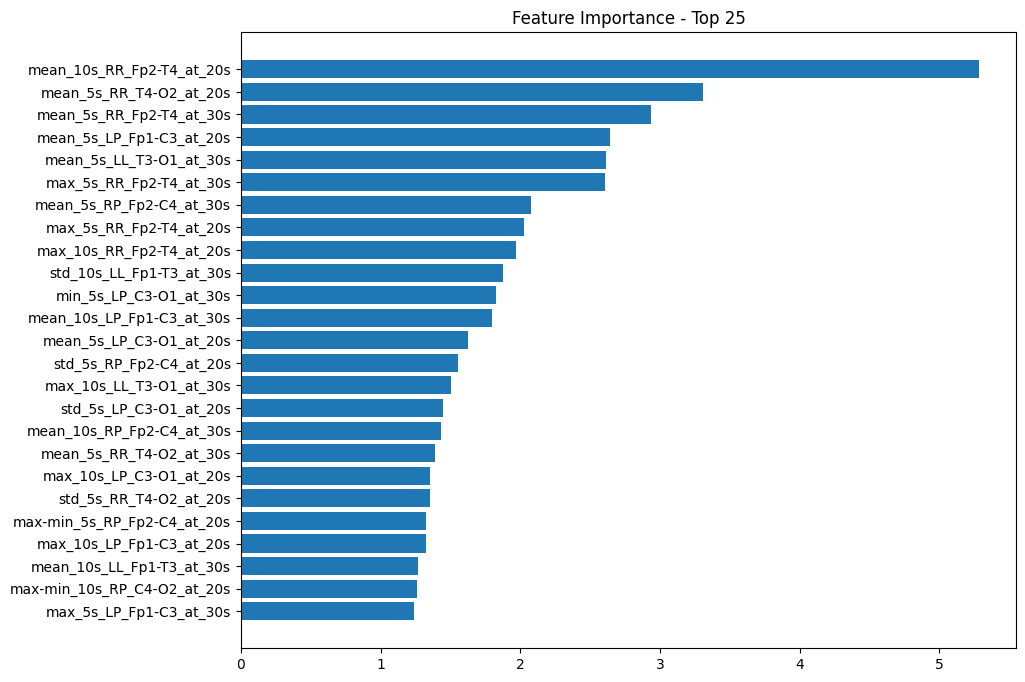

In [40]:
TOP = 25

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 8))
plt.barh(np.arange(len(sorted_idx))[-TOP:], feature_importance[sorted_idx][-TOP:], align='center')
plt.yticks(np.arange(len(sorted_idx))[-TOP:], np.array(FEATURES)[sorted_idx][-TOP:])
plt.title(f'Feature Importance - Top {TOP}')
plt.show()

# CV Score for CatBoost
This is CV score for our CatBoost model.

In [41]:
import sys
sys.path.append('../input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

oof.head()

,0,1,2,3,4,5,id
0,0.114855,0.145735,0.214305,0.053410,0.139116,0.332579,0
1,0.085300,0.286442,0.098151,0.073346,0.111114,0.345648,1
2,0.086845,0.179419,0.068360,0.086357,0.102310,0.476709,2
3,0.124651,0.136705,0.175629,0.058304,0.194761,0.309950,3
4,0.138887,0.075563,0.048817,0.088508,0.104025,0.544201,4


In [42]:
true.head()

,0,1,2,3,4,5,id
0,0.0,0.727273,0.0,0.136364,0.000000,0.136364,0
1,0.0,0.933333,0.0,0.000000,0.000000,0.066667,1
2,0.0,0.333333,0.0,0.000000,0.333333,0.333333,2
3,1.0,0.000000,0.0,0.000000,0.000000,0.000000,3
4,0.0,0.230769,0.0,0.461538,0.000000,0.307692,4


In [43]:
# TARGETSの各列を正規化
oof_data = oof[[0, 1, 2, 3, 4, 5]].values
oof_data = oof_data / oof_data.sum(axis=1,keepdims=True)
oof[[0, 1, 2, 3, 4, 5]] = oof_data

In [44]:
oof.head()

,0,1,2,3,4,5,id
0,0.114855,0.145735,0.214305,0.053410,0.139116,0.332579,0
1,0.085300,0.286442,0.098151,0.073346,0.111114,0.345648,1
2,0.086845,0.179419,0.068360,0.086357,0.102310,0.476709,2
3,0.124651,0.136705,0.175629,0.058304,0.194761,0.309950,3
4,0.138887,0.075563,0.048817,0.088508,0.104025,0.544201,4


In [45]:
temp = pl.from_pandas(oof)

In [46]:
cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

CV Score KL-Div for CatBoost = 1.175070359521645


In [47]:
import sys
sys.path.append('../input/kaggle-kl-div')
from kaggle_kl_div import score

oof = pd.DataFrame(all_oof.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(all_true.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Score KL-Div for CatBoost =',cv)

# CV Score KL-Divの保存
with open(f'models/CV_Score_v{VER}.txt', 'w') as f:
    f.write(str(cv) + "\n")

CV Score KL-Div for CatBoost = 1.175070359521645
